# Chapter 4, Exercise 2: Full MNIST

> Complete all the steps in this chaper using the full MNIST dataset, not just 3s and 7s.

I'm going to follow most of the steps...I'm going to skip the parts about solving the linear equation.

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # Life, the Universe, and Everything

from fastai.vision.all import *

The [fast.ai datasets](https://course.fast.ai/datasets) include MNIST, not just the sample -- so let's do that.

In [4]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/aardvark/.fastai/data/mnist_png/training'),Path('/home/aardvark/.fastai/data/mnist_png/testing')]

Let's look at a random 8:

In [5]:
eights = (path / 'training/8').ls().sorted()
im8_path = eights[1]
im8 = Image.open(im8_path)
im8

Let's compare tensors and arrays:

In [6]:
array(im8)[5:15, 5:15]

array([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
       [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
       [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
       [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
       [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
       [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
       [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
       [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=uint8)

In [7]:
tensor(im8)[5:15, 5:15]

tensor([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
        [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
        [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
        [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
        [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
        [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
        [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
        [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=torch.uint8)

Now let's convert the tensor version of im8 to a dataframe, because Pandas has display _down_.

In [8]:
im8_t = tensor(im8)
df = pd.DataFrame(im8_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,58,125,245,187,254,255,214,125,225,157,35,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,118,253,253,253,253,253,253,253,253,253,249,136,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,242,253,253,253,253,253,253,253,253,253,253,251,137,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,194,253,253,253,253,108,19,56,48,140,253,253,250,235,235,225,46,0,0,0,0,0,0
9,0,0,0,0,0,73,198,253,253,253,245,188,71,76,201,253,253,253,253,253,195,68,0,0,0,0,0,0


Now, let's get the average of each of the numbers.  Remember:  that means stacking them, then taking the mean.

In [9]:
ndata = list(range(10)) # This will hold all the everythings
ndata

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

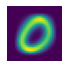

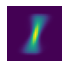

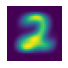

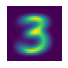

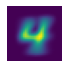

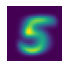

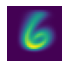

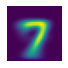

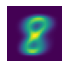

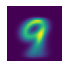

In [10]:
for i in range(10):
    paths = (path / 'training' / '{}'.format(i)).ls().sorted()
    tensor_indiv = [tensor(Image.open(p)) for p in paths]
    ndata[i] = {}
    ndata[i]['tensor_stack'] = torch.stack(tensor_indiv).float() / 255
    ndata[i]['tensor_mean'] = ndata[i]['tensor_stack'].mean(0)
    show_image(ndata[i]['tensor_mean'])

Okay, not bad progress for one night!  Next up: pg 140, figuring out distance from the average.  We've got `im8` from earlier, so let's try that.

In [11]:
im8

In [12]:
ndata[8]['tensor_stack'].size(), ndata[9]['tensor_mean'].size()

(torch.Size([5851, 28, 28]), torch.Size([28, 28]))

<AxesSubplot:>

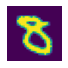

In [13]:
show_image(im8_t - ndata[8]['tensor_mean'])

Let's see if taking the mean difference does the trick:

In [14]:
for i in range(10):
    diff = (im8_t - ndata[i]['tensor_mean']).mean()
    print("im8 - {}: {}".format(i, diff))

im8 - 0: 55.30491638183594
im8 - 1: 55.40231704711914
im8 - 2: 55.329341888427734
im8 - 3: 55.33678436279297
im8 - 4: 55.35694885253906
im8 - 5: 55.34956359863281
im8 - 6: 55.34101486206055
im8 - 7: 55.36378860473633
im8 - 8: 55.32815933227539
im8 - 9: 55.35573959350586


Huh...first of all, zero is the closest match (lowest difference), followed by 8.  Second, they're all *really* close.  Did I miss something?  Let's go back to the original....aha!  I forgot about mean *absolute* difference, and *root mean squared*.  Let's try again.

In [15]:
for i in range(10):
    l1_diff = (im8_t - ndata[i]['tensor_mean']).abs().mean()
    l2_diff = ((im8_t - ndata[i]['tensor_mean'])**2).mean().sqrt()
    print(i, l1_diff, l2_diff)

0 tensor(55.4415) tensor(111.7371)
1 tensor(55.4551) tensor(111.8267)
2 tensor(55.4441) tensor(111.7579)
3 tensor(55.4206) tensor(111.7357)
4 tensor(55.4443) tensor(111.7857)
5 tensor(55.4369) tensor(111.7665)
6 tensor(55.4288) tensor(111.7568)
7 tensor(55.4384) tensor(111.7835)
8 tensor(55.4317) tensor(111.7462)
9 tensor(55.4337) tensor(111.7744)


This is still really weird.  What's going on here?  Let's take a look at the average 8 with Pandas, like we did before:

In [16]:
df = pd.DataFrame(ndata[8]['tensor_mean'])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042,0.000146,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000131,0.000306,0.000523,0.000912,0.001631,0.002182,0.003089,0.003394,0.003456,0.002774,0.001684,0.001235,0.001324,0.000745,0.000501,0.000164,0.000028,0.000000,0.000000
4,0.000000,0.000000,0.000021,0.000000,0.000000,0.000027,0.000129,0.000954,0.002995,0.007111,0.015124,0.029257,0.051305,0.081390,0.111440,0.131845,0.134542,0.117827,0.091799,0.065212,0.043178,0.025043,0.011749,0.005167,0.002347,0.001049,0.000357,0.000040
5,0.000000,0.000000,0.000000,0.000000,0.000033,0.000410,0.002219,0.007849,0.020884,0.046356,0.089147,0.163629,0.264151,0.371977,0.465476,0.526044,0.539430,0.500334,0.411611,0.305475,0.203752,0.124000,0.067980,0.033654,0.014151,0.005314,0.001153,0.000032
6,0.000000,0.000000,0.000000,0.000000,0.000483,0.002475,0.010285,0.029995,0.070067,0.135887,0.236548,0.371098,0.509215,0.623946,0.697022,0.730529,0.724861,0.686317,0.602463,0.487167,0.356250,0.236846,0.141929,0.076771,0.034013,0.012367,0.002594,0.000217
7,0.000000,0.000000,0.000000,0.000064,0.002210,0.008659,0.027718,0.070105,0.141110,0.245296,0.379738,0.518490,0.618694,0.660528,0.648303,0.627855,0.608056,0.599911,0.590380,0.532148,0.430145,0.309680,0.199834,0.116783,0.054332,0.017322,0.003773,0.000320
8,0.000000,0.000000,0.000000,0.000893,0.005261,0.017767,0.049708,0.110292,0.202361,0.332076,0.470365,0.565895,0.594329,0.541709,0.451761,0.395156,0.393332,0.434783,0.501470,0.521458,0.453216,0.346357,0.237076,0.139555,0.066911,0.022379,0.004549,0.000487
9,0.000000,0.000000,0.000000,0.001215,0.008087,0.024644,0.065079,0.135225,0.245898,0.382396,0.502687,0.549436,0.506476,0.389927,0.278163,0.232206,0.275027,0.372516,0.479408,0.523295,0.465601,0.352535,0.234077,0.136494,0.063976,0.021182,0.004424,0.000460


Well, that looks good...but all the values are reals, in the range 0..1.  im8 by contrast is between 0 & 255.  Let's try a random image from the stacked version to make sure I got things right.

<AxesSubplot:>

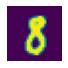

In [17]:
test_8 = ndata[8]['tensor_stack'][42]
show_image(test_8)

In [18]:
for i in range(10):
    l1_diff = (test_8 - ndata[i]['tensor_mean']).abs().mean()
    l2_diff = ((test_8 - ndata[i]['tensor_mean'])**2).mean().sqrt()
    print(i, l1_diff, l2_diff)

0 tensor(0.1823) tensor(0.3155)
1 tensor(0.1215) tensor(0.2784)
2 tensor(0.1569) tensor(0.2739)
3 tensor(0.1258) tensor(0.2303)
4 tensor(0.1626) tensor(0.3028)
5 tensor(0.1403) tensor(0.2531)
6 tensor(0.1553) tensor(0.2870)
7 tensor(0.1527) tensor(0.2944)
8 tensor(0.1226) tensor(0.2224)
9 tensor(0.1409) tensor(0.2714)


*That's* better!



Let's make a function for that.

In [19]:
def l1_diff(image_tensor):
    l1_diffs = {}
    lowest_diff = 1
    best_guess = -1
    for i in range(10):
        l1_diff = (image_tensor - ndata[i]['tensor_mean']).abs().mean()
        if l1_diff < lowest_diff:
            lowest_diff = l1_diff
            best_guess = i
        l1_diffs[i] = l1_diff
    return best_guess, l1_diffs

def l2_diff(image_tensor):
    l2_diffs = {}
    lowest_diff = 1
    for i in range(10):
        l2_diff = ((image_tensor - ndata[i]['tensor_mean'])**2).mean().sqrt()
        if l2_diff < lowest_diff:
            lowest_diff = l2_diff
            best_guess = i
        l2_diffs[i] = l2_diff
    return best_guess, l2_diffs

In [20]:
guess, table = l1_diff(test_8)
print("l1 diff best guess:", guess)
print("Table: ", table)
print()

guess, table = l2_diff(test_8)
print("l2 diff best guess:", guess)
print("Table: ", table)

l1 diff best guess: 1
Table:  {0: tensor(0.1823), 1: tensor(0.1215), 2: tensor(0.1569), 3: tensor(0.1258), 4: tensor(0.1626), 5: tensor(0.1403), 6: tensor(0.1553), 7: tensor(0.1527), 8: tensor(0.1226), 9: tensor(0.1409)}

l2 diff best guess: 8
Table:  {0: tensor(0.3155), 1: tensor(0.2784), 2: tensor(0.2739), 3: tensor(0.2303), 4: tensor(0.3028), 5: tensor(0.2531), 6: tensor(0.2870), 7: tensor(0.2944), 8: tensor(0.2224), 9: tensor(0.2714)}


Right, and PyTorch has these!

In [21]:
for i in range(10):
    # print("l1 {}: {}".format(i, F.l1_loss(test_8, ndata[i]['tensor_mean'])))
    print("l2 {}: {}".format(i, F.mse_loss(test_8, ndata[i]['tensor_mean']).sqrt()))
          

l2 0: 0.31545567512512207
l2 1: 0.2783662676811218
l2 2: 0.27391108870506287
l2 3: 0.23034287989139557
l2 4: 0.30281949043273926
l2 5: 0.25313061475753784
l2 6: 0.28700628876686096
l2 7: 0.29442763328552246
l2 8: 0.22235290706157684
l2 9: 0.271424263715744


Okay, time to try the validation data.

In [22]:
valid_ndata = list(range(10)) # This will hold all the validation everythings
for i in range(10):
    paths = (path / 'testing' / '{}'.format(i)).ls().sorted()
    tensor_indiv = [tensor(Image.open(p)) for p in paths]
    valid_ndata[i] = {}
    valid_ndata[i]['tensor_stack'] = torch.stack(tensor_indiv).float() / 255

In [23]:
valid_ndata[8]['tensor_stack'].shape

torch.Size([974, 28, 28])

Let's make tensor-fied versions of our distance functions:

In [24]:
def mnist_l1_dist(a, b):
    return (a-b).abs().mean((-1, -2))

def mnist_l2_dist(a, b):
    return ((a-b)**2).mean((-1, -2)).sqrt()

In [25]:
mnist_l2_dist(valid_ndata[8]['tensor_stack'], ndata[8]['tensor_mean'])

tensor([0.2013, 0.2244, 0.2193, 0.2073, 0.2543, 0.2633, 0.2204, 0.2435, 0.2059,
        0.2228, 0.3478, 0.2294, 0.2068, 0.2116, 0.2639, 0.2403, 0.2978, 0.2371,
        0.2860, 0.2412, 0.2633, 0.2417, 0.2141, 0.2203, 0.2640, 0.2800, 0.2084,
        0.2555, 0.2723, 0.2380, 0.2349, 0.2057, 0.2153, 0.2296, 0.3177, 0.2124,
        0.2118, 0.2925, 0.2007, 0.2195, 0.2414, 0.2316, 0.1989, 0.2780, 0.2436,
        0.2485, 0.2563, 0.2431, 0.2526, 0.1999, 0.2120, 0.2626, 0.2473, 0.2143,
        0.3035, 0.2361, 0.2491, 0.2227, 0.2936, 0.2141, 0.2665, 0.1959, 0.2549,
        0.2931, 0.2414, 0.1944, 0.2042, 0.2280, 0.2066, 0.2558, 0.1962, 0.2577,
        0.2238, 0.2150, 0.2238, 0.2584, 0.2127, 0.2318, 0.2333, 0.2839, 0.1886,
        0.2501, 0.2040, 0.2928, 0.2585, 0.2122, 0.2413, 0.3108, 0.2160, 0.2318,
        0.2943, 0.2143, 0.2542, 0.2201, 0.2350, 0.2278, 0.2891, 0.2068, 0.2652,
        0.2961, 0.2683, 0.2606, 0.2266, 0.2154, 0.2209, 0.2173, 0.2585, 0.2194,
        0.2161, 0.2350, 0.2607, 0.2507, 

Okay:  so now, we can get a properly broadcasted, tensorfied l1/l2 distance for each of our validation data set.  And that's good!  But the next part is tougher: determining which character we have, in a properly broadcasted, tensorfied manner.

Consider:  in the book, we were just trying to distinguish 3s from 7s, so all we had to do was find the minimum of two numbers:

```
def is_3(x)
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)
```

Now, though, we have to find the minimum of 10 distances.

Turns out PyTorch does this.  `min()` will return minimum along a dimension, *and* the indices where the minima were found.  Example:

In [26]:
a = torch.randn(4, 4)
print(a)
torch.min(a, 1)[1]

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624]])


tensor([3, 3, 3, 2])

So if we unsqueeze the testing set...

In [27]:
valid_ndata[9]['tensor_stack'].unsqueeze(1).size()

torch.Size([1009, 1, 28, 28])

...and convert the average images to a single tensor...

torch.Size([10, 28, 28])

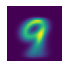

In [28]:
all_average_imgs = torch.zeros(10, 28, 28)
for i in range(1, 10):
    all_average_imgs[i] = ndata[i]['tensor_mean']

show_image(all_average_imgs[9])
all_average_imgs.shape

Okay, so let's give this a try on 9s to start with.

First, let's call `mnist_l1_distance` on the testing 9s, and examine the shape:

In [29]:
example_9_l1_dist = mnist_l1_dist(valid_ndata[9]['tensor_stack'].unsqueeze(1), all_average_imgs)
example_9_l1_dist.shape

torch.Size([1009, 10])

Looking good!  Let's examine one of the lines.  (Probably slightly misleading term, but I'm stuck for a better one right now.)

In [30]:
example_9_l1_dist[123]

tensor([0.1528, 0.1697, 0.1947, 0.1752, 0.1505, 0.1774, 0.1745, 0.1608, 0.1870,
        0.1461])

Cool!  And the min trick?

In [31]:
example_9_l1_dist[123].min(-1)

torch.return_types.min(
values=tensor(0.1461),
indices=tensor(9))

Looks like it got that one right!  Let's see how the whole thing did:

In [32]:
example_9_l1_dist.min(-1)[1]

tensor([1, 9,  ..., 0, 9])

Sweet!  And can we turn that into an accuracy?

In [33]:
example_9_l1_dist.min(-1)[1] == 9

tensor([False,  True,  ..., False,  True])

Looks good....

In [34]:
example_9_right_or_wrong = (example_9_l1_dist.min(-1)[1] == 9)
example_9_right_or_wrong.shape

torch.Size([1009])

Still looking good!  Now to turn it into an accuracy:

In [35]:
example_9_right_or_wrong.float().mean()

tensor(0.6244)

Huzzah!  Although that's not real good...But at any rate: on to the rest of the numbers.

First, l1 distance:

In [36]:
for i in range(10):
    row_to_validate = valid_ndata[i]['tensor_stack'].unsqueeze(1)
    predictions = mnist_l1_dist(row_to_validate, all_average_imgs).min(-1)[1]
    my_accuracy = (predictions == i).float().mean()
    print("{}: Accuracy {}%".format(i, my_accuracy * 100))

0: Accuracy 41.020408630371094%
1: Accuracy 69.42731475830078%
2: Accuracy 38.372093200683594%
3: Accuracy 54.85148620605469%
4: Accuracy 42.769859313964844%
5: Accuracy 23.991031646728516%
6: Accuracy 64.09185791015625%
7: Accuracy 54.280155181884766%
8: Accuracy 44.35318374633789%
9: Accuracy 62.43805694580078%


And now l2 accuracy:

In [37]:
for i in range(10):
    row_to_validate = valid_ndata[i]['tensor_stack'].unsqueeze(1)
    predictions = mnist_l2_dist(row_to_validate, all_average_imgs).min(-1)[1]
    my_accuracy = (predictions == i).float().mean()
    print("{}: Accuracy {}%".format(i, my_accuracy * 100))

0: Accuracy 0.20408162474632263%
1: Accuracy 95.68281555175781%
2: Accuracy 76.8410873413086%
3: Accuracy 80.79208374023438%
4: Accuracy 82.38289642333984%
5: Accuracy 68.60986328125%
6: Accuracy 87.26513671875%
7: Accuracy 83.07392883300781%
8: Accuracy 74.33264923095703%
9: Accuracy 80.77304077148438%


Wow: l2 is a *lot* better, with the exception of 0.  I wonder why that is...

This would be a good place to build a confusion matrix.

# Next: do it with neural networks

I'm beginning at pg 163; pg 149-162 are dealing with the quadratic equation example.

As a reminder, my training and validation data is:

- `ndata[x]['tensor_stack']` where 0 <= x <= 9
- `valid_ndata[x]['tensor_stack']`
- In both cases, the label is the `x` key/index.

The example starts with _all_ the images stacked, so let's do that.

Reminder to myself:

- you can create an empty tensor with `torch.empty(0)`
- tuples are in parentheses, not square brackets -- but those are optional; it's the commas that make the tuple

In [38]:
train_x = torch.empty(0)
train_y = torch.empty(0, dtype=torch.long)

valid_x = torch.empty(0)
valid_y = torch.empty(0, dtype=torch.long)

for i in range(10):
    images = ndata[i]['tensor_stack'].view(-1, 28*28)
    valid_images = valid_ndata[i]['tensor_stack'].view(-1, 28*28)
    # First the data...
    train_x = torch.cat((train_x,       images))
    valid_x = torch.cat((valid_x, valid_images))
    # ...then the label:
    train_y = torch.cat((train_y, tensor([i] * len(images))))
    valid_y = torch.cat((valid_y, tensor([i] * len(valid_images))))
                        
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

Now the dataset:

In [39]:
dset =       list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

x, y =                   dset[0]
valid_x, valid_y = valid_dset[0]

x.shape, y, valid_x.shape, valid_y

(torch.Size([784]), tensor(0), torch.Size([784]), tensor(0))

Now let's initialize some parameters up in this joint!

In [40]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28, 1))
bias = init_params(1)

weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

Now we can calculate a prediction for one image.

Question: why do we have `weights.T` instead of just `weights`?  This appears to be a shortcut/convenience function for `Tensor` -- which is _different_ from just `tensor`.  [This post](https://discuss.pytorch.org/t/what-is-the-difference-between-tensor-and-tensor-is-tensor-going-to-be-deprecated-in-the-future/17134/4) has some information on this, as does [this StackExchange answer](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor).

However, it's not clear to me why we're using one over the other here.  What I *can* see is that there's a huge difference between these predictions:

In [41]:
uppercase_t_prediction = (train_x[54321] * weights.T).sum() + bias
lowercase_t_prediction = (train_x[54321] * weights).sum() + bias

uppercase_t_prediction, lowercase_t_prediction

(tensor([11.4140], grad_fn=<AddBackward0>),
 tensor([2863.4946], grad_fn=<AddBackward0>))

What the frak?

In [42]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds[54321]

tensor([11.4140], grad_fn=<SelectBackward>)

Let's try graphing, just for fun:

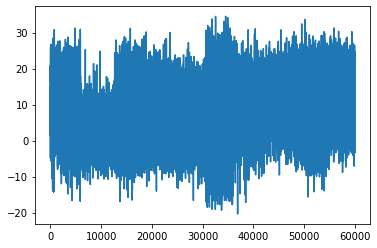

In [43]:
plt.plot(preds.detach().numpy())

Let's try adjusting a weight to see what we get:

In [44]:
weights[0] *= 1.0001
preds = linear1(train_x)
preds[54321]

tensor([11.4140], grad_fn=<SelectBackward>)

Also, though: how do we calculate the accuracy here?

At first, I tried this:

In [45]:
# Crashes the kernel :-(
# (preds == train_y.float()).float().mean().item()

Some investigation showed that there was a mismatch of dimensions between the two:

In [46]:
preds.size(), train_y.size()

(torch.Size([60000, 1]), torch.Size([60000]))

And if you look at comparing a subset of both, you see that the size of the resulting tensor increases:

In [47]:
(preds[:10] == train_y[:10])

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False]])

In fact, it goes up by the square of the size:

In [48]:
(preds[:20] == train_y[:20]).size()

torch.Size([20, 20])

No wonder the kernel kept crashing!  So let's try this:

In [49]:
(preds[:20].squeeze() == train_y[:20])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

That's better!  Now the whole thing:

In [50]:
(preds.squeeze() == train_y).float().mean().item()

0.0

I believe that means we're exactly wrong.   But wait!  This is not our prediction -- our prediction is -- uh...

Uh, our prediction is just wrong.

The linear output is fine for a binary classification.  But this is a case where we're doing a classification -- 10 different classes.  I think here, it's much more appropriate to skip immediately to a full blown neural network.

Thus, skipping ahead to pg 177...

In [51]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10), # 10 outputs, one for each class
    # nn.Softmax(0) # Finally, use softmax here
)

In [52]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
dls = DataLoaders(dl, valid_dl)

So what about predictions?  Well, we want to find the highest prediction; the index of that highest prediction is the class (eg, index of 2 means we've predicted a 2); and we want to see if that matches our labels.

So:

In [53]:
X, y = first(valid_dl)
# Remember, the dataloader is returning a batch of 256:
X.shape, y.shape 

(torch.Size([256, 784]), torch.Size([256]))

Let's try just one, first:

In [54]:
# simple_net(X[0]), simple_net(X[0]).sigmoid().max(0)[1].item(), y.item()
# , simple_net(X[0]).max(0)[1].item() == y[0].item()

Now, a whole batch:

In [55]:
# simple_net(X), simple_net(X).max(1)[1], simple_net(X).max(1)[1] == y, (simple_net(X).max(1)[1] == y).float().mean()

# Quick note

Previously, the model did *not* have SoftMax() as the final layer, and the results were *all* false.  Adding in SoftMax gave us a 17% accuracy rate -- still crappy, but much much better.

Cool!

But....but what about loss?

This is where we have to skip ahead to Chapter 5, which has details on an appropriate loss for multi-category classification.  And now, we get to learn about *cross-entropy loss*.

# Goddammit

A crash in my browser tab meant I lost a lot of work. `=_=`
- Labels for classification problems like this need to be long, not float.  Correcting the call to `torch.empty()` fixed that.

- I named a variable up above `accuracy`, which conflicted with the FastAI function `accuracy`.  I had to remove that to get the next call (copied from pg 180 in the book) to work.

- Before I figured _that_ out, I was trying to use `metrics=accuracy_multi`, and that was not working:  it complained about different sizes for `model(X)` vs `y`.  The numbers were off by 10:  2560 vs 256.  It seems pretty clear that's related to the number of neurons in the output.  I realized I was misunderstanding this sentence in [the documentation](https://docs.fast.ai/metrics#accuracy_multi):

>  Warning: All functions defined in this section are intended for single-label classification and targets that are not one-hot encoded. For multi-label problems or one-hot encoded targets, use the version suffixed with multi.

This is distinguishing predictions where only one label (out of many) is applied, vs where one *or more* labels (out of many) are applied.  My bad.

- There are a number of cases where I've made some mistake, and my warning has a been a 12-level deep backtrace with an entirely unhelpful message.  This is frustrating, and feels like something that could be improved in the FastAI library.

- Changing the learning rate from 0.1 to 0.001 *vastly* improved training.

In [56]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)

In [57]:
learn.fit(40, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.479677,2.822940,0.100900,00:00
1,0.918183,2.818058,0.102100,00:00
2,0.666834,2.418672,0.172500,00:00
3,0.541519,2.139493,0.277200,00:00
4,0.471714,1.950529,0.341000,00:00
5,0.428870,1.809751,0.383300,00:00
6,0.400412,1.697330,0.412400,00:00
7,0.379967,1.603793,0.436900,00:00
8,0.364417,1.522985,0.459100,00:00
9,0.351993,1.452178,0.478800,00:00


This is handy; [source](https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2):

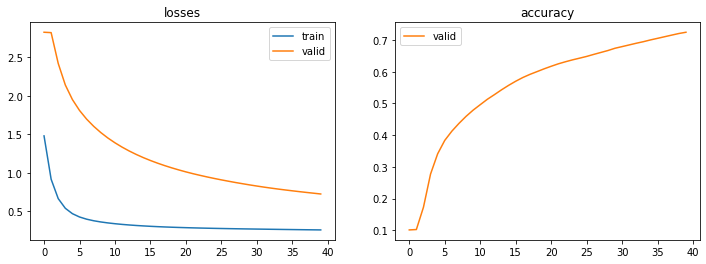

In [58]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    
learn.recorder.plot_metrics()

I had to adjust the arguments for ImageDataLoaders to account for the different directory names.  Again, this feels like a sharp edge in FastAI.

In [59]:
dl_2 = ImageDataLoaders.from_folder(path, train='training', valid='testing')
learn_2 = cnn_learner(dl_2, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn_2.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.087237,0.039545,0.987500,07:31


Whoah!  More than 8 minutes training time on my laptop (no GPU), but that's crazy accurate.

Comparing performance on Paperspace is illustrative:

- Storage speed is *much* slower.  Loading the images takes a long time.
- Training resnet18 took ~ 2 minutes -- about 4 times faster than my laptop.

# Postscript

In watching the lecture for this chapter, Jeremy Howard showed how you could visualize what the layer is learning.

Start by noting that `simple_net` has three elements:

In [60]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
)

Now let's look at the zeroth element:

In [61]:
simple_net[0]

Linear(in_features=784, out_features=30, bias=True)

We can decompose this into the weights and biases

In [63]:
w, b = simple_net[0].parameters()

And look at the zeroth neuron:

In [68]:
w[0].view(28, 28).shape

torch.Size([28, 28])

Thanks to [this StackExchange post](https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645), we can plot *all* of the neurons in one go:


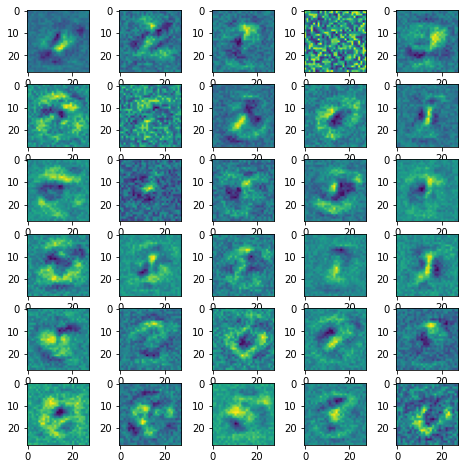

In [84]:
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
w=28
h=28
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 6
w, b = simple_net[0].parameters()
for i in range(1, columns*rows + 1):  
    img = w[i-1].view(28, 28).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


This is so cool!  The two frames that appear to be nearly random are interesting -- maybe those could be dropped without causing any problems.

It's interesting to think about framing this as a "Council of 30":  30 somewhat stupid people who vote on what number they're seeing, and whose votes are weighted in different ways.